# Implementación de modelos Transformer para generación de texto estilo Shakespeare

In [ ]:
!pip install huggingface_hub[hf_xet]
#!pip install hf_xet

import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import warnings
warnings.filterwarnings("ignore")

# Establecer semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 17.9 MB/s eta 0:00:00


In [ ]:
# Comprobar disponibilidad de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilizando dispositivo: {device}")

Utilizando dispositivo: cuda


# PARTE 1: PREPARACIÓN DE DATOS

In [ ]:
def cargar_y_preparar_datos(archivo):
    """Carga el texto y lo divide en conjuntos de entrenamiento y validación"""
    # Cargar el corpus completo
    with open(archivo, 'r', encoding='utf-8') as f:
        corpus = f.read()

    # Dividir en conjunto de entrenamiento (90%) y validación (10%)
    split_idx = int(len(corpus) * 0.9)
    train_corpus = corpus[:split_idx]
    val_corpus = corpus[split_idx:]

    print(f"Longitud del corpus de entrenamiento: {len(train_corpus)} caracteres")
    print(f"Longitud del corpus de validación: {len(val_corpus)} caracteres")

    return train_corpus, val_corpus

# Constantes para el modelo
BLOCK_SIZE = 64  # Tamaño del contexto para las predicciones
BATCH_SIZE = 64  # Tamaño del lote para entrenamiento
VOCAB_SIZE = 50257  # Tamaño del vocabulario (igual que GPT-2)
MODEL_DIM = 384  # Dimensión del modelo
HEADS_NUM = 6  # Número de cabezas de atención
BLOCKS_NUM = 6  # Número de bloques del transformador

# PARTE 2: IMPLEMENTACIÓN DEL MODELO DESDE CERO

In [ ]:
class SelfAttention(nn.Module):
    """Implementación de la capa de auto-atención"""
    def __init__(self, embed_dim, head_dim, block_size):
        super().__init__()
        # Proyecciones para Query, Key y Value
        self.q = nn.Linear(embed_dim, head_dim, bias=False)
        self.k = nn.Linear(embed_dim, head_dim, bias=False)
        self.v = nn.Linear(embed_dim, head_dim, bias=False)
        # Máscara causal para evitar ver tokens futuros
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape  # batch, tiempo, canales
        # Proyecciones
        q = self.q(x)  # (B, T, head_dim)
        k = self.k(x)  # (B, T, head_dim)
        v = self.v(x)  # (B, T, head_dim)

        # Calcular scores de atención (producto escalar)
        scores = q @ k.transpose(-2, -1) / (k.shape[-1] ** 0.5)  # (B, T, T)

        # Aplicar máscara causal
        scores = scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))

        # Softmax y multiplicación por valores
        attn_weights = F.softmax(scores, dim=-1)  # (B, T, T)
        output = attn_weights @ v  # (B, T, head_dim)

        return output

In [ ]:
class MultiHeadAttention(nn.Module):
    """Implementación de la atención multi-cabeza"""
    def __init__(self, heads_num, embed_dim, head_dim, block_size):
        super().__init__()
        self.heads = nn.ModuleList([
            SelfAttention(embed_dim, head_dim // heads_num, block_size)
            for _ in range(heads_num)
        ])
        self.dense = nn.Linear(head_dim, head_dim, bias=False)

    def forward(self, x):
        # x: [batch_size, block_size, embed_dim]
        heads_output = [h(x) for h in self.heads]
        # Concatenar las salidas de cada cabeza
        concat = torch.cat(heads_output, dim=-1)
        # Proyección final
        output = self.dense(concat)
        return output

In [ ]:
class FeedForward(nn.Module):
    """Implementación de la capa feed-forward"""
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.dense1 = nn.Linear(in_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # Aplicar la primera transformación lineal y ReLU
        hidden = F.gelu(self.dense1(x))
        # Aplicar la segunda transformación lineal
        output = self.dense2(hidden)
        return output

In [ ]:
class Block(nn.Module):
    """Bloque del transformador con atención multi-cabeza y feed-forward"""
    def __init__(self, heads_num, model_dim, block_size):
        super().__init__()
        self.attention = MultiHeadAttention(heads_num, model_dim, model_dim, block_size)
        self.ln1 = nn.LayerNorm(model_dim)
        self.ff = FeedForward(model_dim, model_dim * 4, model_dim)
        self.ln2 = nn.LayerNorm(model_dim)
        # Capas de dropout para regularización
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)

    def forward(self, x):
        # Atención + conexión residual + normalización
        attn_output = self.attention(x)
        attn_output = self.drop1(attn_output)
        x = self.ln1(x + attn_output)

        # Feed-forward + conexión residual + normalización
        ff_output = self.ff(x)
        ff_output = self.drop2(ff_output)
        x = self.ln2(x + ff_output)

        return x

In [ ]:
class CustomGPT(nn.Module):
    """Implementación completa de un modelo tipo GPT"""
    def __init__(self, vocab_size, model_dim, block_size, blocks_num, heads_num):
        super().__init__()
        # Embedding de tokens y posiciones
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.position_embedding = nn.Embedding(block_size, model_dim)
        self.ln_final = nn.LayerNorm(model_dim)

        # Bloques del transformador
        self.blocks = nn.Sequential(*[
            Block(heads_num, model_dim, block_size) for _ in range(blocks_num)
        ])

        # Capa final para producir logits
        self.head = nn.Linear(model_dim, vocab_size, bias=False)

        # Dropout para regularización
        self.drop = nn.Dropout(0.1)

        # Guardar tamaño del bloque para generación
        self.block_size = block_size

    def forward(self, x):
        # x: [batch_size, block_size]
        B, T = x.shape

        # Obtener embeddings de tokens
        token_emb = self.token_embedding(x)  # [B, T, model_dim]

        # Obtener embeddings de posición
        positions = torch.arange(0, T, dtype=torch.long, device=x.device)
        pos_emb = self.position_embedding(positions)  # [T, model_dim]

        # Sumar embeddings y aplicar dropout
        x = token_emb + pos_emb
        x = self.drop(x)

        # Pasar por los bloques del transformador
        x = self.blocks(x)

        # Normalización final
        x = self.ln_final(x)

        # Proyección a logits de vocabulario
        logits = self.head(x)  # [B, T, vocab_size]

        return logits

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=None):
        """Genera texto a partir de un contexto inicial"""
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Si el contexto es demasiado largo, tomar solo los últimos tokens
                idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

                # Obtener predicciones
                logits = self(idx_cond)

                # Tomar solo los logits del último token
                logits = logits[:, -1, :] / temperature

                # Aplicar sampling con top-k si se especifica
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')

                # Aplicar sampling con top-p (nucleus sampling) si se especifica
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    # Eliminar tokens con probabilidad acumulada > top_p
                    sorted_indices_to_remove = cumulative_probs > top_p
                    # Desplazar la máscara para mantener al menos un token
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    # Dispersar los índices a eliminar
                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    logits[indices_to_remove] = float('-inf')

                # Obtener distribución de probabilidad
                probs = F.softmax(logits, dim=-1)

                # Muestrear próximo token
                next_token = torch.multinomial(probs, num_samples=1)

                # Añadir el token generado al contexto
                idx = torch.cat((idx, next_token), dim=1)

        return idx

# PARTE 3: TOKENIZADOR Y DATASET

In [ ]:
class CustomTokenizer:
    """Tokenizador simple basado en caracteres o palabras con vocabulario fijo"""
    def __init__(self, vocab_size=VOCAB_SIZE):
        self.vocab_size = vocab_size
        self.token_to_id = {}
        self.id_to_token = {}
        self.unk_token_id = 0

    def fit(self, text):
        """Construye el vocabulario a partir del texto"""
        # Extraer caracteres únicos (tokenización por caracteres)
        chars = sorted(list(set(text)))

        if len(chars) + 1 > self.vocab_size:
            print(f"Advertencia: El número de caracteres únicos ({len(chars)}) excede el tamaño del vocabulario. Algunos caracteres serán ignorados.")
            chars = chars[:self.vocab_size - 1]  # Reservar espacio para token <unk>

        # Asignar IDs
        self.token_to_id = {ch: i+1 for i, ch in enumerate(chars)}  # 0 reservado para <unk>
        self.token_to_id['<unk>'] = 0

        # Crear mapeo inverso
        self.id_to_token = {i: ch for ch, i in self.token_to_id.items()}

        print(f"Vocabulario construido con {len(self.token_to_id)} tokens")

    def encode(self, text):
        """Convierte texto a IDs de tokens"""
        return [self.token_to_id.get(ch, self.unk_token_id) for ch in text]

    def decode(self, ids):
        """Convierte IDs de tokens a texto"""
        return ''.join([self.id_to_token.get(id, '<unk>') for id in ids])

In [ ]:
class ShakespeareDataset(Dataset):
    """Dataset para el corpus de Shakespeare"""
    def __init__(self, corpus, tokenizer, block_size):
        self.tokenizer = tokenizer
        self.block_size = block_size

        # Tokenizar todo el corpus
        self.data = torch.tensor(tokenizer.encode(corpus), dtype=torch.long)

    def __len__(self):
        # Número de bloques posibles (con superposición)
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # Obtener un bloque de tokens
        x = self.data[idx:idx + self.block_size]
        # Target es el token siguiente para cada posición
        y = self.data[idx + 1:idx + self.block_size + 1]
        return x, y

# PARTE 4: ENTRENAMIENTO DEL MODELO DESDE CERO

In [ ]:
def train_custom_model(model, train_dataloader, val_dataloader, epochs=3, lr=3e-4):
    """Entrena el modelo personalizado"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_dataloader))

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        epoch_loss = 0
        for step, (x, y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)

            # Forward pass
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), y.view(-1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            if step % 100 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = F.cross_entropy(logits.view(-1, VOCAB_SIZE), y.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Guardar el mejor modelo
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "custom_gpt_shakespeare.pt")
            print(f"Modelo guardado con pérdida de validación: {best_val_loss:.4f}")

    return train_losses, val_losses

# PARTE 5: FINE-TUNING DE GPT-2

In [ ]:
class GPT2Dataset(Dataset):
    """Dataset para fine-tuning de GPT-2"""
    def __init__(self, corpus, tokenizer, block_size):
        self.examples = []

        # Tokenizar el corpus en bloques
        tokenized_text = tokenizer.encode(corpus)

        # Crear ejemplos con limitación de longitud a 1024 tokens (máximo de GPT-2)
        for i in range(0, len(tokenized_text) - block_size, block_size):
            # Asegurar que el ejemplo no exceda el límite de longitud
            example = tokenized_text[i:i + min(block_size, 1024)]
            self.examples.append(example)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return torch.tensor(self.examples[idx], dtype=torch.long)

def train_gpt2_model(model, tokenizer, train_dataloader, val_dataloader, epochs=3, lr=5e-5):
    """Realiza fine-tuning de GPT-2"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_dataloader))

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        epoch_loss = 0
        for step, batch in enumerate(train_dataloader):
            inputs = batch.to(device)

            # Forward pass con labels = inputs desplazados
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

            if step % 50 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                inputs = batch.to(device)
                outputs = model(inputs, labels=inputs)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Guardar el mejor modelo
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "gpt2_shakespeare.pt")
            print(f"Modelo guardado con pérdida de validación: {best_val_loss:.4f}")

    return train_losses, val_losses

def generate_text_gpt2(model, tokenizer, prompt, max_length=100, temperature=0.8, top_p=0.9):
    """Genera texto con el modelo GPT-2 fine-tuned"""
    model.eval()

    # Tokenizar el prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Añadir una máscara de atención explícita
    attention_mask = torch.ones_like(input_ids).to(device)

    # Generar texto
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,  # Añadir explícitamente la máscara
        max_length=input_ids.shape[1] + max_length,
        temperature=temperature,
        top_p=top_p,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3  # Prevenir repeticiones de n-gramas
    )

    # Decodificar el texto generado
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

# PARTE 6: EJECUCIÓN PRINCIPAL

Longitud del corpus de entrenamiento: 1003854 caracteres
Longitud del corpus de validación: 111540 caracteres

=== Entrenamiento de modelo personalizado ===
Vocabulario construido con 66 tokens
Número de parámetros del modelo personalizado: 49260288
Epoch 1, Step 0, Loss: 11.0592
Epoch 1, Step 100, Loss: 2.4268
Epoch 1, Step 200, Loss: 2.0904
Epoch 1, Step 300, Loss: 1.9259
Epoch 1, Step 400, Loss: 1.7942
Epoch 1, Step 500, Loss: 1.6960
Epoch 1, Step 600, Loss: 1.6464
Epoch 1, Step 700, Loss: 1.6488
Epoch 1, Step 800, Loss: 1.4969
Epoch 1, Step 900, Loss: 1.5291
Epoch 1, Step 1000, Loss: 1.4822
Epoch 1, Step 1100, Loss: 1.4957
Epoch 1, Step 1200, Loss: 1.4909
Epoch 1, Step 1300, Loss: 1.4450
Epoch 1, Step 1400, Loss: 1.4776
Epoch 1, Step 1500, Loss: 1.3895
Epoch 1, Step 1600, Loss: 1.4115
Epoch 1, Step 1700, Loss: 1.3670
Epoch 1, Step 1800, Loss: 1.3960
Epoch 1, Step 1900, Loss: 1.3713
Epoch 1, Step 2000, Loss: 1.3173
Epoch 1, Step 2100, Loss: 1.3537
Epoch 1, Step 2200, Loss: 1.2806
Ep

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Número de parámetros de GPT-2: 124439808


Token indices sequence length is longer than the specified maximum sequence length for this model (301966 > 1024). Running this sequence through the model will result in indexing errors
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1, Step 0, Loss: 5.2835
Epoch 1, Step 50, Loss: 4.0484
Epoch 1, Step 100, Loss: 3.9309
Epoch 1, Step 150, Loss: 3.7428
Epoch 1, Step 200, Loss: 3.5373
Epoch 1, Step 250, Loss: 3.7631
Epoch 1, Train Loss: 3.8263, Val Loss: 3.5834
Modelo guardado con pérdida de validación: 3.5834
Epoch 2, Step 0, Loss: 3.5192
Epoch 2, Step 50, Loss: 3.5425
Epoch 2, Step 100, Loss: 3.4476
Epoch 2, Step 150, Loss: 3.6151
Epoch 2, Step 200, Loss: 3.4772
Epoch 2, Step 250, Loss: 3.4970
Epoch 2, Train Loss: 3.5130, Val Loss: 3.5550
Modelo guardado con pérdida de validación: 3.5550
Epoch 3, Step 0, Loss: 3.2591
Epoch 3, Step 50, Loss: 3.5193
Epoch 3, Step 100, Loss: 3.6697
Epoch 3, Step 150, Loss: 3.0950
Epoch 3, Step 200, Loss: 3.5756
Epoch 3, Step 250, Loss: 3.0751
Epoch 3, Train Loss: 3.4147, Val Loss: 3.5595


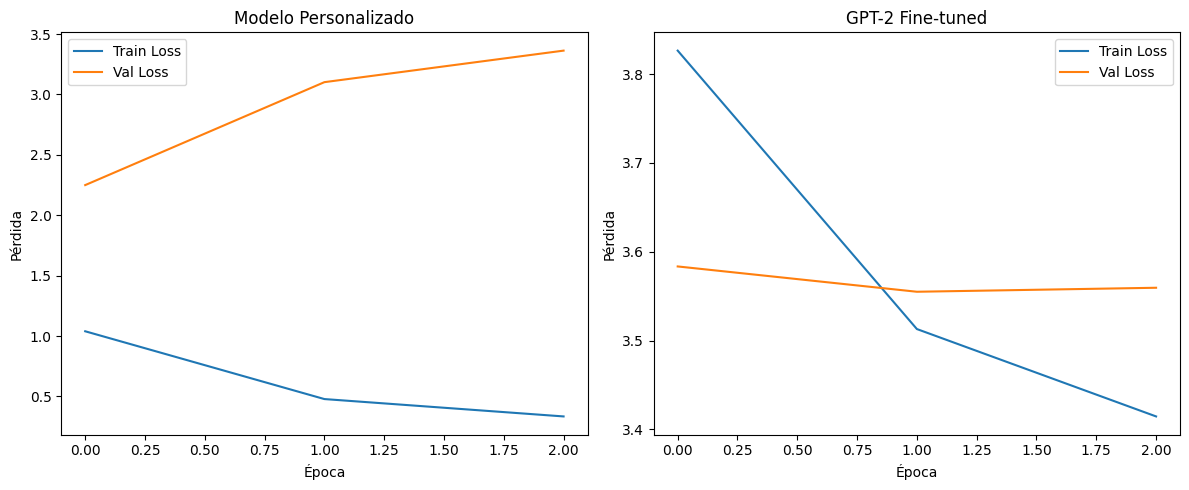


=== Generación de texto con modelo personalizado ===

Ejemplo 1 (Modelo personalizado):
To be or not to be, if thou dost not know
The noble tribunes are that is not Romeo bear so?

Nurse:
O lamentable day!



Ejemplo 2 (Modelo personalizado):
All the world's a stage,
To lay in a lady's chamber-headed here,
That is set Lord Stanley quarrel have learn'd his suit.
But

Ejemplo 3 (Modelo personalizado):
Friends, Romans, countrymen, but this clouds,
Which to use us with the tables. I would
these people do ask the merry one and the

=== Generación de texto con GPT-2 fine-tuned ===

Ejemplo 1 (GPT-2 fine-tuned):
To be or not to be,
Which is your choice for the better; and in that you do choose it. Now here's my wife:--let me hear her answer by word of mouth:My lord Clarence! I have had all these letters as a note upon hand lately?Well now comes this letter from him wherein he calls his lady-maid Isabelle out again:'I love thee well'--how couldst thou tell what thyself was told when she first

In [ ]:
def main():
    # Cargar datos
    train_corpus, val_corpus = cargar_y_preparar_datos('Shakespeare.txt')

    # 1. Entrenar modelo personalizado
    print("\n=== Entrenamiento de modelo personalizado ===")

    # Crear tokenizador personalizado
    custom_tokenizer = CustomTokenizer(vocab_size=VOCAB_SIZE)
    custom_tokenizer.fit(train_corpus)  # Solo usar datos de entrenamiento

    # Crear datasets
    train_dataset = ShakespeareDataset(train_corpus, custom_tokenizer, BLOCK_SIZE)
    val_dataset = ShakespeareDataset(val_corpus, custom_tokenizer, BLOCK_SIZE)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Crear y entrenar modelo personalizado
    custom_model = CustomGPT(
        vocab_size=VOCAB_SIZE,
        model_dim=MODEL_DIM,
        block_size=BLOCK_SIZE,
        blocks_num=BLOCKS_NUM,
        heads_num=HEADS_NUM
    ).to(device)

    print(f"Número de parámetros del modelo personalizado: {sum(p.numel() for p in custom_model.parameters())}")

    custom_train_losses, custom_val_losses = train_custom_model(
        custom_model,
        train_dataloader,
        val_dataloader,
        epochs=3
    )

    # 2. Fine-tuning de GPT-2
    print("\n=== Fine-tuning de GPT-2 ===")

    # Cargar tokenizador y modelo de GPT-2
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

    # Ajustar el tokenizador
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
    # Garantizar que el modelo sepa que el pad token y el eos token son distintos
    gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id

    print(f"Número de parámetros de GPT-2: {sum(p.numel() for p in gpt2_model.parameters())}")

    # Crear datasets para GPT-2
    train_dataset_gpt2 = GPT2Dataset(train_corpus, gpt2_tokenizer, BLOCK_SIZE)
    val_dataset_gpt2 = GPT2Dataset(val_corpus, gpt2_tokenizer, BLOCK_SIZE)

    # Usar un tamaño de batch más pequeño para GPT-2 debido a limitaciones de memoria
    gpt2_batch_size = 16

    train_dataloader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=gpt2_batch_size, shuffle=True)
    val_dataloader_gpt2 = DataLoader(val_dataset_gpt2, batch_size=gpt2_batch_size, shuffle=False)

    # Entrenar GPT-2
    gpt2_train_losses, gpt2_val_losses = train_gpt2_model(
        gpt2_model,
        gpt2_tokenizer,
        train_dataloader_gpt2,
        val_dataloader_gpt2,
        epochs=3
    )

    # 3. Visualizar resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(custom_train_losses, label='Train Loss')
    plt.plot(custom_val_losses, label='Val Loss')
    plt.title('Modelo Personalizado')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(gpt2_train_losses, label='Train Loss')
    plt.plot(gpt2_val_losses, label='Val Loss')
    plt.title('GPT-2 Fine-tuned')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.savefig('comparacion_modelos.png')
    plt.show()

    # 4. Generar ejemplos de texto
    print("\n=== Generación de texto con modelo personalizado ===")

    # Cargar el mejor modelo personalizado
    custom_model.load_state_dict(torch.load("custom_gpt_shakespeare.pt"))

    # Generar texto con el modelo personalizado
    prompts = [
        "To be or not to be,",
        "All the world's a stage,",
        "Friends, Romans, countrymen,"
    ]

    for i, prompt in enumerate(prompts):
        # Codificar el prompt
        encoded_prompt = torch.tensor([custom_tokenizer.encode(prompt)], dtype=torch.long).to(device)

        # Generar texto
        generated_ids = custom_model.generate(
            encoded_prompt,
            max_new_tokens=100,
            temperature=0.8,
            top_p=0.9
        )

        # Decodificar el texto generado
        generated_text = custom_tokenizer.decode(generated_ids[0].tolist())

        print(f"\nEjemplo {i+1} (Modelo personalizado):")
        print(generated_text)

    print("\n=== Generación de texto con GPT-2 fine-tuned ===")

    # Cargar el mejor modelo GPT-2
    gpt2_model.load_state_dict(torch.load("gpt2_shakespeare.pt"))

    # Generar texto con GPT-2
    for i, prompt in enumerate(prompts):
        generated_text = generate_text_gpt2(
            gpt2_model,
            gpt2_tokenizer,
            prompt,
            max_length=100,
            temperature=0.8,
            top_p=0.9
        )

        print(f"\nEjemplo {i+1} (GPT-2 fine-tuned):")
        print(generated_text)

    # 5. Imprimir resultados finales
    print("\n=== Resultados finales ===")
    print(f"Mejor pérdida de validación del modelo personalizado: {min(custom_val_losses):.4f}")
    print(f"Mejor pérdida de validación de GPT-2 fine-tuned: {min(gpt2_val_losses):.4f}")

    # Guardar checkpoints finales
    optimizer_custom = torch.optim.AdamW(custom_model.parameters(), lr=3e-4, weight_decay=0.01)
    optimizer_gpt2 = torch.optim.AdamW(gpt2_model.parameters(), lr=5e-5, weight_decay=0.01)

    torch.save({
        'model_state_dict': custom_model.state_dict(),
        'optimizer_state_dict': optimizer_custom.state_dict(),  # Usar optimizer_custom
        'val_loss': min(custom_val_losses),
    }, 'custom_model_checkpoint.pt')

    torch.save({
        'model_state_dict': gpt2_model.state_dict(),
        'optimizer_state_dict': optimizer_gpt2.state_dict(),  # Usar optimizer_gpt2
        'val_loss': min(gpt2_val_losses),
    }, 'gpt2_model_checkpoint.pt')

    print("Checkpoints finales guardados.")


if __name__ == "__main__":
    main()